The Atomic Simulation Environment library (ASE) is useful for managing and performing calculations with structural data in python. In this notebook, I will review the following:  
* Creating a new structure
* ASE calculators
* Importing structural data
* Optimizing a structure
* Performing a molecular dynamics simulation

In [1]:
import sys
sys.path.append('../code')
from Molecular_Dynamics import make_diatomic, assign_calc, make_optimized_diatomic, generate_md_traj
from Visualize_Structures import Structure3DPlot, Structure3DAnimation
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from ase import Atoms
from ase.io import read
from ase import build


### Creating a new structure

ASE makes it very easy to generate some common organic molecules such as water or benzene.

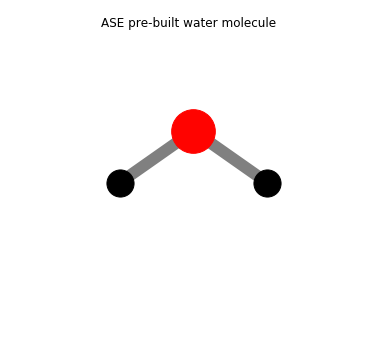

In [31]:
water = build.molecule("H2O")
Structure3DPlot(water, elevation=0, title = "ASE pre-built water molecule").Plot();

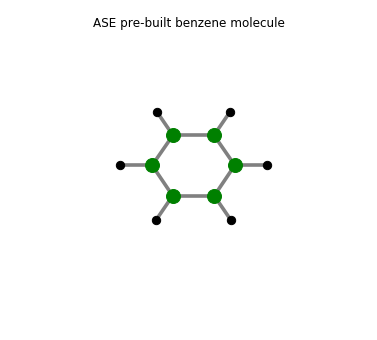

In [32]:
benzene = build.molecule("C6H6")
Structure3DPlot(benzene, title = "ASE pre-built benzene molecule").Plot();

See the complete list of molecules you can access this way below

In [5]:
from ase.collections import g2
",   ".join(g2.names)

'PH3,   P2,   CH3CHO,   H2COH,   CS,   OCHCHO,   C3H9C,   CH3COF,   CH3CH2OCH3,   HCOOH,   HCCl3,   HOCl,   H2,   SH2,   C2H2,   C4H4NH,   CH3SCH3,   SiH2_s3B1d,   CH3SH,   CH3CO,   CO,   ClF3,   SiH4,   C2H6CHOH,   CH2NHCH2,   isobutene,   HCO,   bicyclobutane,   LiF,   Si,   C2H6,   CN,   ClNO,   S,   SiF4,   H3CNH2,   methylenecyclopropane,   CH3CH2OH,   F,   NaCl,   CH3Cl,   CH3SiH3,   AlF3,   C2H3,   ClF,   PF3,   PH2,   CH3CN,   cyclobutene,   CH3ONO,   SiH3,   C3H6_D3h,   CO2,   NO,   trans-butane,   H2CCHCl,   LiH,   NH2,   CH,   CH2OCH2,   C6H6,   CH3CONH2,   cyclobutane,   H2CCHCN,   butadiene,   C,   H2CO,   CH3COOH,   HCF3,   CH3S,   CS2,   SiH2_s1A1d,   C4H4S,   N2H4,   OH,   CH3OCH3,   C5H5N,   H2O,   HCl,   CH2_s1A1d,   CH3CH2SH,   CH3NO2,   Cl,   Be,   BCl3,   C4H4O,   Al,   CH3O,   CH3OH,   C3H7Cl,   isobutane,   Na,   CCl4,   CH3CH2O,   H2CCHF,   C3H7,   CH3,   O3,   P,   C2H4,   NCCN,   S2,   AlCl3,   SiCl4,   SiO,   C3H4_D2d,   H,   COF2,   2-butyne,   C2H5,   BF3, 

----


ASE also lets you easily build periodic structures with common space groups using build.bulk

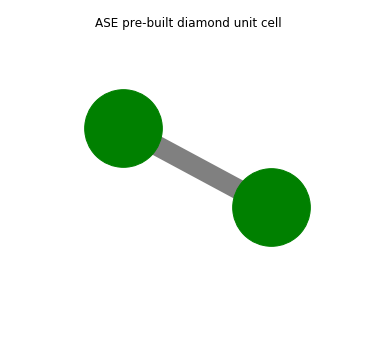

In [33]:
diamond = build.bulk("C", 'diamond')
Structure3DPlot(diamond, title="ASE pre-built diamond unit cell").Plot();

You start with a unit cell, which you can extend to a supercell which can be useful for visualization

In [35]:
scaling_matrix = np.identity(3)*3
super_diamond = build.make_supercell(diamond, scaling_matrix)
Structure3DAnimation([super_diamond], verbose=False, rotate=True, rotation_rates = {"elev":0, "azim":10 }, title="3x3x3 diamond supercell").Plot()

For all the details on what periodic structures you can build, see the following documentation

In [36]:
build.bulk??

Signature:
build.bulk(
    name,
    crystalstructure=None,
    a=None,
    b=None,
    c=None,
    *,
    alpha=None,
    covera=None,
    u=None,
    orthorhombic=False,
    cubic=False,
    basis=None,
)
Source:   
def bulk(name, crystalstructure=None, a=None, b=None, c=None, *, alpha=None,
         covera=None, u=None, orthorhombic=False, cubic=False,
         basis=None):
    """Creating bulk systems.

    Crystal structure and lattice constant(s) will be guessed if not
    provided.

    name: str
        Chemical symbol or symbols as in 'MgO' or 'NaCl'.
    crystalstructure: str
        Must be one of sc, fcc, bcc, tetragonal, bct, hcp, rhombohedral, 
        orthorhombic, mlc, diamond, zincblende, rocksalt, cesiumchloride, 
        fluorite or wurtzite.
    a: float
        Lattice constant.
    b: float
        Lattice constant.  If only a and b is given, b will be interpreted
        as c instead.
    c: float
        Lattice constant.
    alpha: float
        Angle in degree

### ASE Calculators

ASE calculators are potential energy surfaces, i.e. they calculate atomic energies and forces. There are several simplistic calculators that are implemented within the ASE library. In general they are too inaccurate to be useful in a meaningful way for all but a small subset of structures, e.g. diatomic molecules. However, they are computationally cheap so they are useful for getting familiar with ASE, for debugging and for modeling diatomics

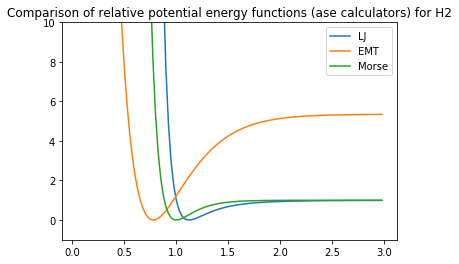

In [40]:
# Plot different potentials
pots = ["LJ", "EMT", "Morse"]
diatomic_element = "H"
lengths = np.arange(.05, 3, .025)

for pot in pots:
    energies = [make_diatomic(element=diatomic_element, verbose=False, 
                           bond_length=l, calc_type=pot).get_potential_energy() for l in lengths]
    energies = np.array(energies) - np.min(energies)
    plt.plot(lengths, energies, label=pot)

plt.title("Comparison of relative potential energy functions (ase calculators) for {}2".format(diatomic_element))
plt.ylim(bottom= -1, top=10)
plt.legend()
plt.show()

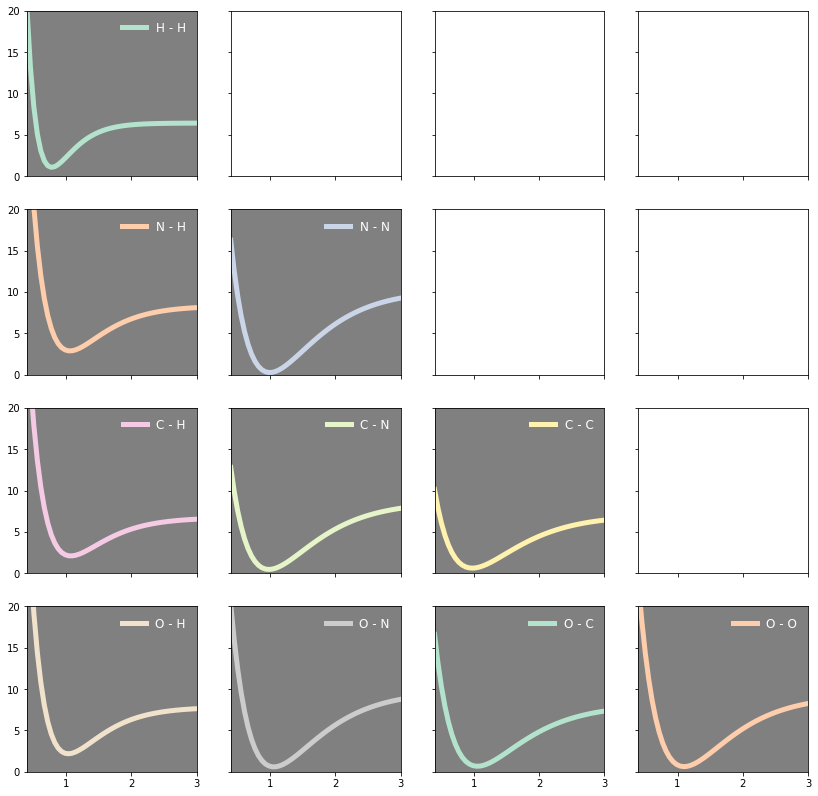

In [6]:
some_elements = ["H", "N", "C", "O"]
bond_lengths = np.linspace(.4, 3, 50)
calc_type = "EMT"
molecule_potential_energies = {}

#fig = plt.figure(figsize=(6.5,6))
fig, axs = plt.subplots(len(some_elements), len(some_elements), sharex='all', sharey='all', figsize=(14,14))
axs_flat = axs.flatten()
axs[0][0].set_ylim(bottom=0, top=20)
axs[0][0].set_yticks([0,5,10,15,20])
axs[0][0].set_xlim(left=min(bond_lengths), right=max(bond_lengths))
axs[0][0].set_xticks([1,2,3])
axs[0][0].grid(False)

palette = plt.get_cmap("Pastel2")
palette_size = len(palette.colors)
palette_itr = 0

for i in range(len(some_elements)):
    for j in range(i+1):#len(some_elements)):
        molecule_formula_i_j = some_elements[i] + some_elements[j]
        molecule_name_i_j = some_elements[i] + " - " + some_elements[j]
        energies_i_j = []
        for bond_length_k in bond_lengths:
            molecule_i_j = Atoms(molecule_formula_i_j, [(0., 0., 0.), (0., 0., bond_length_k)])
            molecule_i_j = assign_calc(molecule_i_j, calc_type)
            energy_i_j_k = molecule_i_j.get_potential_energy()
            energies_i_j.append(energy_i_j_k)
        axs[i][j].plot(bond_lengths, energies_i_j, label=molecule_name_i_j, lw=5, c=palette(palette_itr))
        palette_itr = (palette_itr + 1) % palette_size
        axs[i][j].set_facecolor("gray")
        legend_i_j = axs[i][j].legend(fontsize=12)
        legend_frame_i_j = legend_i_j.get_frame()
        legend_frame_i_j.set_linewidth(0)
        legend_frame_i_j.set_facecolor("gray")#(.9,.9,.9))
        plt.setp(legend_i_j.get_texts(), color='w')




### Importing your own structure

In [7]:
distorted_propanols = read("../data/distorted_propanol.extxyz.gz", ":100")
one_distorted_propanol = distorted_propanols[0]

### Structure Optimization

In [4]:
OptimizedDiatomicBondLengths = {}
pots = ["LJ", "EMT", "Morse"]
elements = ["N", "H", "O"]
lengths = np.arange(.5, 3, .05)
for element in elements:
    OptimizedDiatomicBondLengths[element] = {}
    for pot in pots:
        optimized_bond_length = distance.euclidean(*make_optimized_diatomic(element=element, calc_type=pot).get_positions())
        OptimizedDiatomicBondLengths[element][pot] = optimized_bond_length
        print("Optimized bond length of {}2 using the {} potential is {:.2f} angstroms".format(element, pot, optimized_bond_length))

Optimized bond length of N2 using the LJ potential is 1.12 angstroms
Optimized bond length of N2 using the EMT potential is 1.00 angstroms
Optimized bond length of N2 using the Morse potential is 1.00 angstroms
Optimized bond length of H2 using the LJ potential is 1.12 angstroms
Optimized bond length of H2 using the EMT potential is 0.78 angstroms
Optimized bond length of H2 using the Morse potential is 1.00 angstroms
Optimized bond length of O2 using the LJ potential is 1.12 angstroms
Optimized bond length of O2 using the EMT potential is 1.10 angstroms
Optimized bond length of O2 using the Morse potential is 1.00 angstroms


If your optimization step isn't small enough, you might "bounce out" of the bond

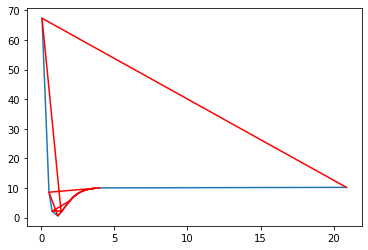

In [9]:

atoms_opt_list = make_optimized_diatomic(element="N", bond_length = 4, optimizer_type="MDMin", 
                                         optimize_step=.2, return_history=True)


dists = np.array([distance.euclidean(*atom.get_positions()) for atom in atoms_opt_list])
eners = np.array([atom.get_potential_energy() for atom in atoms_opt_list])
sorted_indices = np.argsort(dists)
plt.plot(dists[sorted_indices], eners[sorted_indices])
plt.plot(dists, eners, "r")

### Molecular Dynamics

Nitrogen atom energy:  5.10 eV
Nitrogen molecule energy:  0.44 eV
Atomization energy:  9.76 eV
Now generating MD trajectory of 500 N₂ molecules at 300 K using VelocityVerlet dynamics
Step 100: Energy per atom: Epot = 0.140eV  Ekin = 0.083eV (T=383K) Etot = 0.223eV
Step 200: Energy per atom: Epot = 0.152eV  Ekin = 0.071eV (T=330K) Etot = 0.223eV
Step 300: Energy per atom: Epot = 0.220eV  Ekin = 0.004eV (T= 19K) Etot = 0.224eV
Step 400: Energy per atom: Epot = 0.139eV  Ekin = 0.084eV (T=391K) Etot = 0.223eV
Step 500: Energy per atom: Epot = 0.155eV  Ekin = 0.068eV (T=318K) Etot = 0.223eV


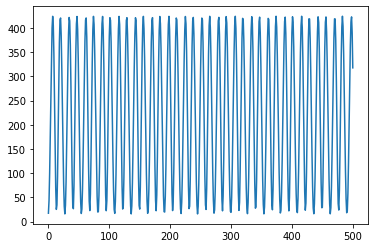

In [5]:

my_trajectory = generate_md_traj(from_diatomic=True, element = "N", nsteps=500, md_type="VelocityVerlet", time_step=1, bond_length=1.1,
                           temperature=300, verbose = True, print_step_size = 100, calc_type="EMT", preoptimize=False)




In [20]:
from Visualize_Structures import Structure3DAnimation

animation = Structure3DAnimation(my_trajectory)
animation.ModifyVisualParameters(adjust_COM="initial", bond_color='b', sidelength=4, frame_rate=40, print_interval = 20, title="Trajectory of N2 molecule")
animation.Plot()

Generating animation frame 0 (0% complete)
Generating animation frame 20 (20% complete)
Generating animation frame 40 (40% complete)
Generating animation frame 60 (60% complete)
Generating animation frame 80 (80% complete)
Generating animation frame 100 (100% complete)


Now generating MD trajectory of 500 H2O structures at 300 K using VelocityVerlet dynamics
Step 100: Energy per atom: Epot = 0.643eV  Ekin = 0.117eV (T=543K) Etot = 0.760eV
Step 200: Energy per atom: Epot = 0.703eV  Ekin = 0.063eV (T=293K) Etot = 0.766eV
Step 300: Energy per atom: Epot = 0.652eV  Ekin = 0.108eV (T=500K) Etot = 0.760eV
Step 400: Energy per atom: Epot = 0.689eV  Ekin = 0.074eV (T=344K) Etot = 0.763eV
Step 500: Energy per atom: Epot = 0.709eV  Ekin = 0.055eV (T=256K) Etot = 0.764eV


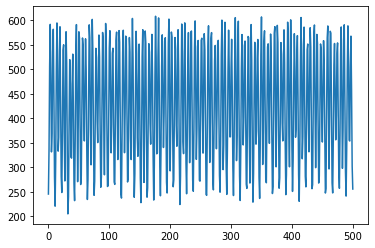

In [15]:
my_trajectory = generate_md_traj(structure = water, from_diatomic=False, nsteps=500, md_type="VelocityVerlet", time_step=1, bond_length=1.1,
                           temperature=300, verbose = True, print_step_size = 100, calc_type="EMT", preoptimize=False)

In [16]:
from Visualize_Structures import Structure3DAnimation

animation = Structure3DAnimation(my_trajectory)
animation.ModifyVisualParameters(adjust_COM="initial", sidelength=4, frame_rate=20, print_interval = 20, title="Trajectory of N2 molecule")
animation.Plot()

Generating animation frame 0 (0% complete)
Generating animation frame 20 (20% complete)
Generating animation frame 40 (40% complete)
Generating animation frame 60 (60% complete)
Generating animation frame 80 (80% complete)
Generating animation frame 100 (100% complete)
